In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [3]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import torch
import json
import matplotlib.pyplot as plt

### Load the Model

In [4]:
modelname = "xlm-roberta-base"

model = AutoModel.from_pretrained(modelname)
tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embed Sentences

In [5]:
frs = []
ens = []

with open("/content/drive/MyDrive/proverb-similarity/raw/fr-en.jsonl", "r") as f:
    for line in f:
        j = json.loads(line)
        fr = j["FR"]
        en = j["EN"]
        
        frs.append(fr)
        ens.append(en)

In [6]:
def embed(sents):
    
    embs = []

    for sent in tqdm(sents):
        encoded_input = tokenizer(sent, padding=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input, output_hidden_states=True)

        embs.append(model_output.last_hidden_state[0,0])
        
    return torch.stack(embs)

In [7]:
fr_embs = embed(frs)
en_embs = embed(ens)

100%|██████████| 475/475 [00:40<00:00, 11.79it/s]


### Get Cosine Similarities

In [8]:
lf = torch.linalg.norm(fr_embs, dim = 1)
le = torch.linalg.norm(en_embs, dim = 1)
pcos = (en_embs @ fr_embs.T) / (lf * le[:,None])

print(f"Average similarity = {torch.mean(pcos):.3f}")

Average similarity = 0.995


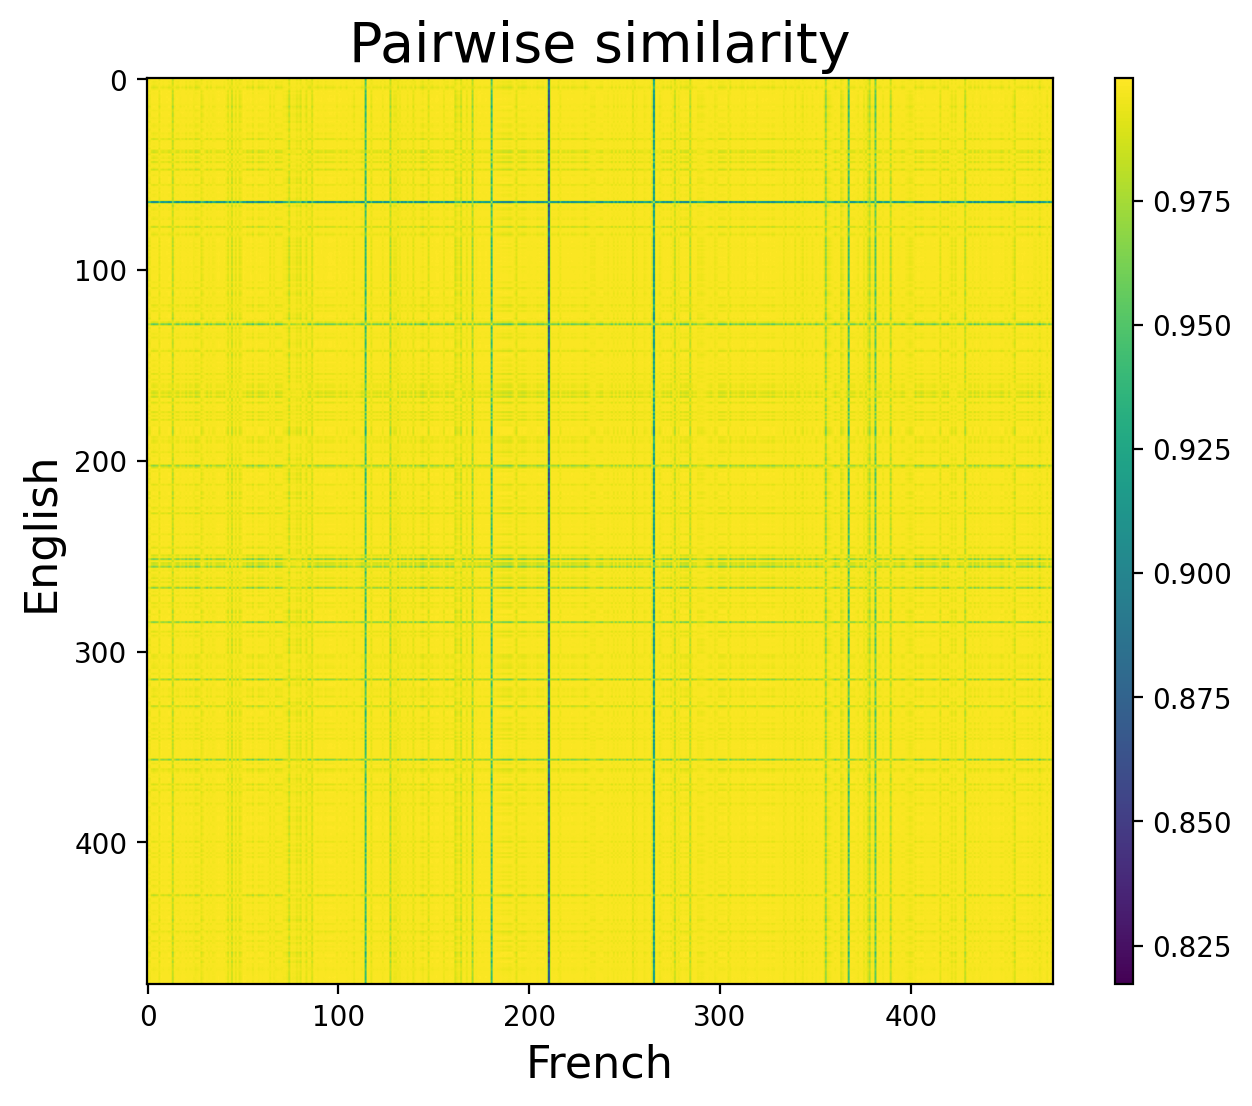

In [9]:
# use a size (a,b) where a>b will make the colorbar align

fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

im = ax.imshow(pcos)

ax.set_title("Pairwise similarity", fontsize = 20)
ax.set_xlabel("French", fontsize = 16)
ax.set_ylabel("English", fontsize = 16)

plt.colorbar(im, ax = ax, aspect=50)

plt.show()

The overall high similarity indicates high uniformity of the pre-trained xlm-roberta-base model.

### Zero-shot Results with Last-layer Embeddings

In [10]:
# MRR

s = pcos.shape[0]

idx = torch.argsort(pcos, dim=1, descending=True)
ranks = (torch.arange(s)[:, None] == idx).nonzero()
MRR = sum(1 / (ranks + 1)[:,1]).item() / s

print(f"MRR = {MRR:.3f}")

MRR = 0.139


In [11]:
# P@K

for K in [1, 5, 10, 20, 50]:

    PatK = sum((ranks + 1)[:,1] <= K).item() / s

    print(f"P@{K} = {PatK:.3f}")

P@1 = 0.099
P@5 = 0.177
P@10 = 0.200
P@20 = 0.236
P@50 = 0.337


TBA:
- Other language pairs.
- Use the embedding from layers other than the last one.
- Case studies.